In [ ]:
!pip install transformers
!pip uninstall torch
!pip install torch

In [ ]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelWithLMHead


def load_model():
    """Load model and tokenizer."""
    tokenizer = AutoTokenizer.from_pretrained("kuppuluri/telugu_bertu",
                                              clean_text=False,
                                              handle_chinese_chars=False,
                                              strip_accents=False,
                                              wordpieces_prefix='##')
    model = AutoModelWithLMHead.from_pretrained("kuppuluri/telugu_bertu",output_hidden_states=True)
    return model, tokenizer


In [ ]:

def get_embedding(sentence, model, tokenizer):
    """Create sentence embedding."""
    input_ids = torch.tensor(tokenizer.encode(sentence)).unsqueeze(0)
    outputs = model(input_ids)
    hidden_states = outputs[1]

    # get last two layers or change accordingly
    last_two_layers = [hidden_states[i] for i in (-1, -2)]
    concatenated_hidden_states = torch.cat(tuple(last_two_layers), dim=-1)

    sentence_embedding = torch.mean(concatenated_hidden_states,
                                    dim=1).squeeze()

    sentence_embedding = sentence_embedding.data.numpy()
    normalized_sentence_embedding = sentence_embedding / np.linalg.norm(
        sentence_embedding)
    return normalized_sentence_embedding


In [ ]:

if __name__ == '__main__':
    sentence = "ర్యాష్‌ డ్రైవింగ్‌ చేసిన సినీ నిర్మాతపై కేసు"
    model, tokenizer = load_model()
    sentence_embedding = get_embedding(sentence, model, tokenizer)
    print(sentence_embedding.shape) 

Downloading:   0%|          | 0.00/191 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/505 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/590k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:925: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

(1536,)


In [ ]:
!pip install tensorflow

In [ ]:

import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import string
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate,Subtract,Multiply,Concatenate
from tensorflow.keras.layers import Conv2D,GlobalMaxPooling2D, LSTM, Dense, Dropout, Input, Activation,BatchNormalization,MaxPooling2D,Bidirectional,Flatten,Lambda
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix
import spacy
import tensorflow as tf

In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

df =pd.read_excel('/content/Telugu_nlp_dataset_final.xlsx')
df = df.iloc[: , 1:]
df=df.dropna()
print(df.shape)
s1 = df['sentance1'].values
s2 = df['sentance2'].values   # independant features
tar = df['target'].values		

(1031, 3)


In [ ]:
def preprocessing(array):
  for i in range(len(array)):
    array[i]=array[i].replace("\n", "")
    array[i]=array[i].replace("\u200c", " ")
    array[i]=array[i].replace(".", "")
  return array


In [ ]:
s1=preprocessing(s1)
s2=preprocessing(s2)


In [ ]:
from nltk import tokenize
r=tokenizer

In [ ]:
features=['f'+str(i) for i in range(1536)]
dfnew=pd.DataFrame(columns=features)

for i in range(len(s1)):
  sentence_embedding = get_embedding(s1[i], model, tokenizer)
  dfnew=dfnew.append(pd.DataFrame([sentence_embedding], columns=features))

In [ ]:
dft=tar

In [ ]:
features=['f'+str(i) for i in range(1536)]
dfnew1=pd.DataFrame(columns=features)

for i in range(len(s2)):
  sentence_embedding = get_embedding(s1[i], model, tokenizer)
  dfnew1=dfnew1.append(pd.DataFrame([sentence_embedding], columns=features))

In [ ]:
dfnew.to_csv('/content/sentance1.csv')

In [ ]:
dfnew1.to_csv('/content/sentance2.csv')

In [ ]:
def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

In [ ]:
def sentance_model(input_shape):
  input1=Input(shape=input_shape)
  input2=Input(shape=input_shape)

  x1=Flatten()(input1)
  x2=Flatten()(input2)

  x3=Subtract()([x1,x2])
  x3=Multiply()([x3,x3])

  x1_ = Multiply()([x1, x1])
  x2_ = Multiply()([x2, x2])
  x4 = Subtract()([x1_, x2_])

  x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([x1, x2])

  conc = Concatenate(axis=-1)([x5,x4,x3])

  x=Dense(100,activation='relu',name='concatenation_layer')(conc)
  x=Dropout(0.01)(x)
  x=Dense(100,activation='relu')(x)
  x=Dropout(0.01)(x)
  output=Dense(1,activation='sigmoid',name='out')(x)


  model=Model([input1,input2],output)
  
  model.compile(optimizer=optimizers.Adam(),loss="binary_crossentropy",metrics=['accuracy'])
  

  return model


In [ ]:
model_1 = sentance_model(input_shape=(1536,))
model_1.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 1536)]       0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 1536)]       0           []                               
                                                                                                  
 flatten_24 (Flatten)           (None, 1536)         0           ['input_25[0][0]']               
                                                                                                  
 flatten_25 (Flatten)           (None, 1536)         0           ['input_26[0][0]']               
                                                                                           

In [ ]:
X_train1, X_val_test1,X_train2,X_val_test2, y_train, y_val_test = train_test_split(dfnew,dfnew1, dft, test_size=0.3, random_state=42)

In [ ]:
filepath ='model_bert.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_alpha = ReduceLROnPlateau(monitor ='val_loss', factor = 0.2, patience = 1, min_lr = 0.001)
callbacks = [checkpoint,reduce_alpha] 

In [ ]:
no_epochs = 150
batch_s=16
history1=model_1.fit([X_train1, X_train2],
          y=y_train,
          epochs=no_epochs,
          batch_size=batch_s,
          validation_data=([X_val_test1,X_val_test2],y_val_test),callbacks=callbacks)

Epoch 1/150
46/46 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.4910
Epoch 1: val_loss improved from inf to 0.69307, saving model to model_bert.h5
46/46 [==============================] - 1s 10ms/step - loss: 0.6934 - accuracy: 0.4910 - val_loss: 0.6931 - val_accuracy: 0.5161 - lr: 0.0010
Epoch 2/150
32/46 [===================>..........] - ETA: 0s - loss: 0.6931 - accuracy: 0.5098
Epoch 2: val_loss did not improve from 0.69307
46/46 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.4993 - val_loss: 0.6933 - val_accuracy: 0.4839 - lr: 0.0010
Epoch 3/150
44/46 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5114
Epoch 3: val_loss did not improve from 0.69307
46/46 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5062 - val_loss: 0.6933 - val_accuracy: 0.4839 - lr: 0.0010
Epoch 4/150
35/46 [=====================>........] - ETA: 0s - loss: 0.6932 - accuracy: 0.4500
Epoch 4: val_loss did

In [ ]:
x=dfnew.values[1]
x.shape

(1536,)

In [ ]:
model_1.evaluate([X_val_test1,X_val_test2],y_val_test)

10/10 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.4839


[0.6941124796867371, 0.4838709533214569]

In [ ]:
def precision(y_true, y_pred):
  num=sum([y_true[i]*y_pred[i][0] for i in range(len(y_true))])
  den=sum([y_pred[i][0] for i in  range(len(y_true))])
  if den==0:
    return 0
  precision_val=num/den
  return precision_val

def recall(y_true, y_pred):
  num=sum([y_true[i]*y_pred[i][0] for i in range(len(y_true))])
  den=sum([y_true[i] for i in  range(len(y_true))])
  if den==0:
    return 0
  recall_val=num/den
  return recall_val

def f1_score(y_true, y_pred):
  prec=precision(y_true, y_pred)
  reca=recall(y_true, y_pred)
  f1_score_val= 2 * (prec * reca) / (prec + reca )
  return f1_score_val


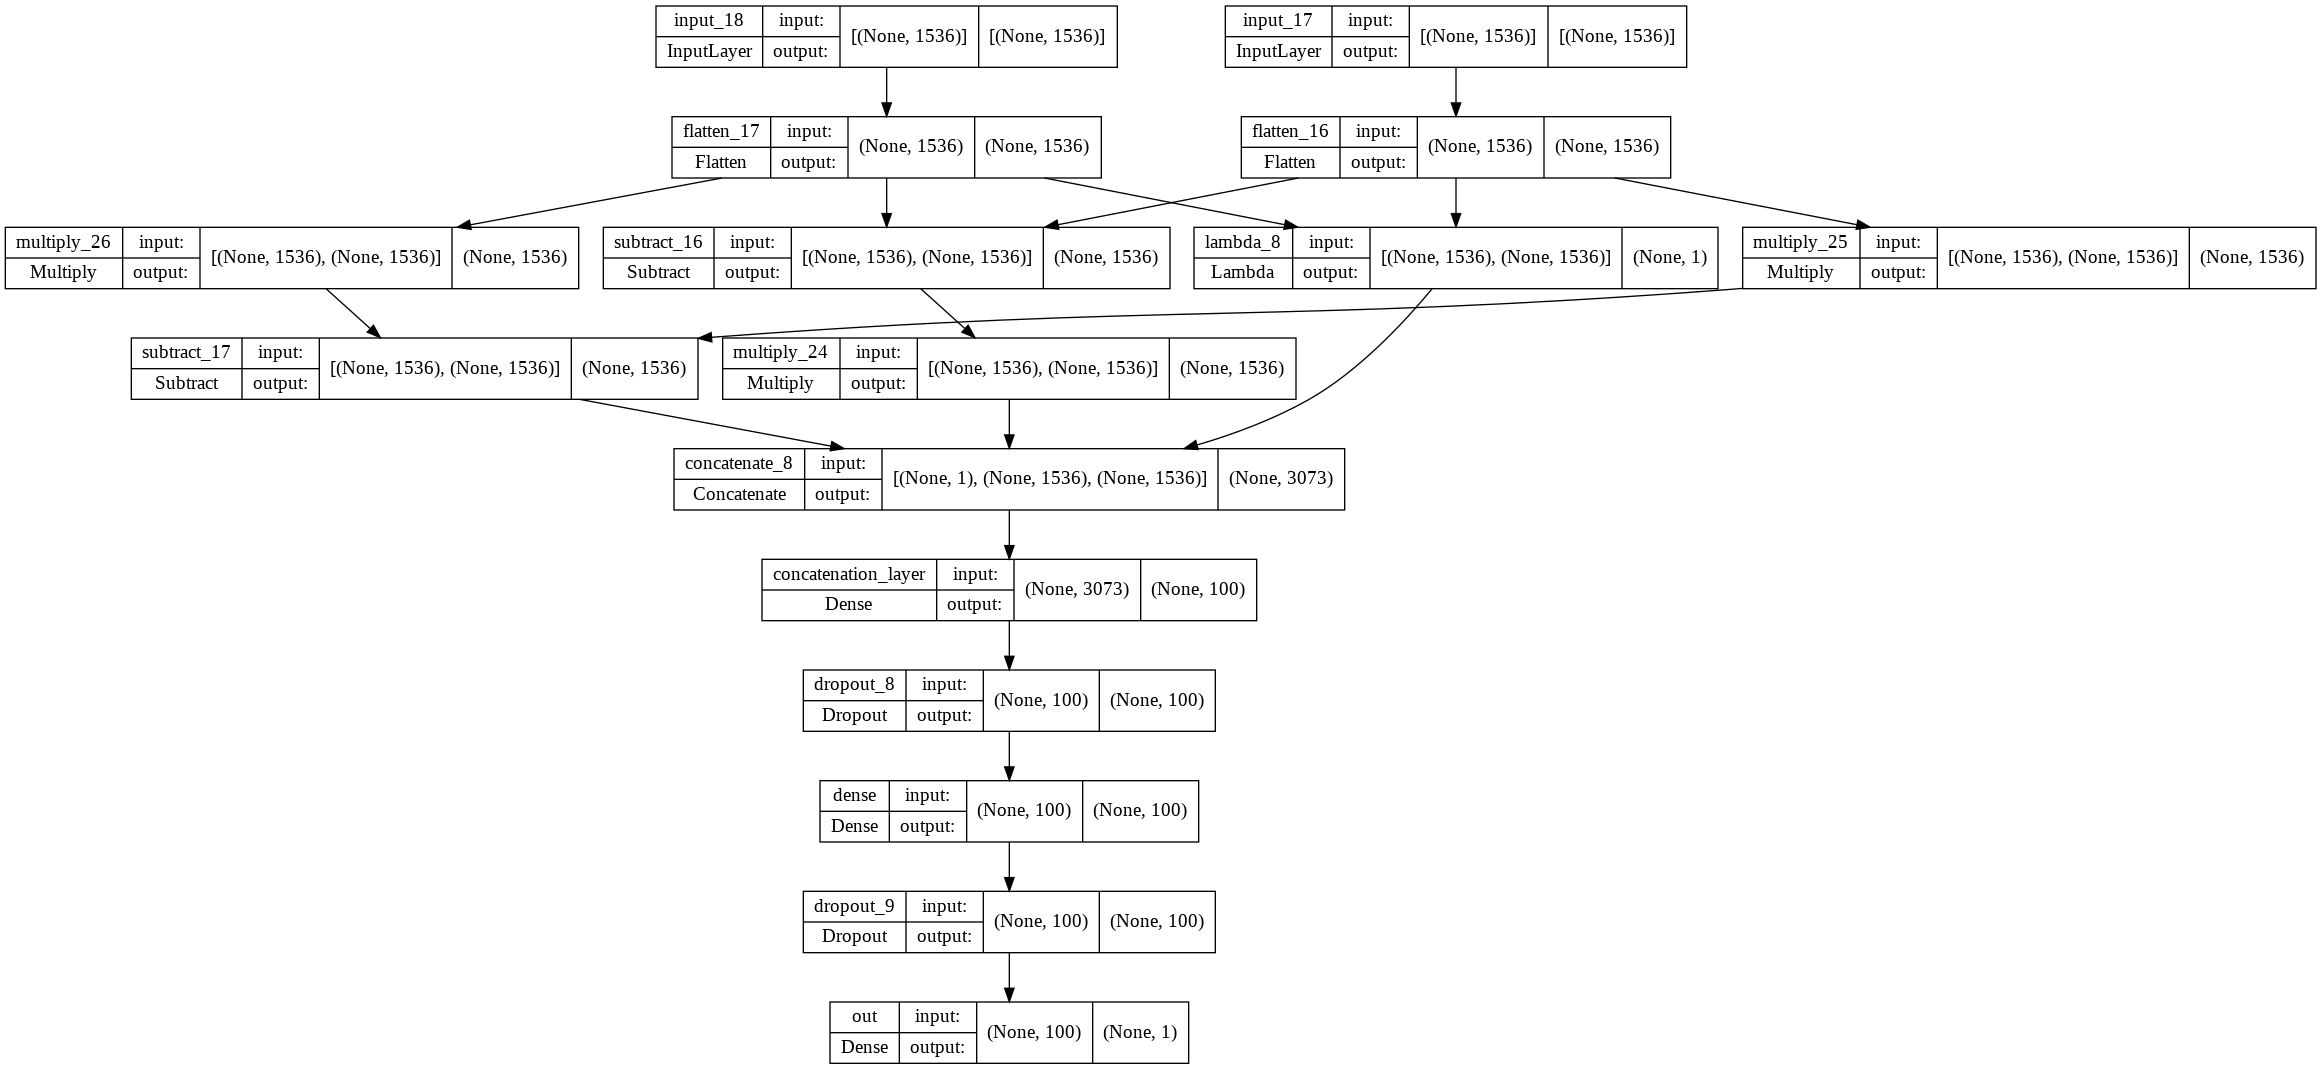

In [ ]:

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
val=model_1.predict([X_val_test1,X_val_test2])

In [ ]:
print("precision= ",precision(y_val_test, val))
print("recall= ",recall(y_val_test, val))
print("f1_score= ",f1_score(y_val_test, val))


precision=  0.5161290322580645
recall=  0.4888762831687927
f1_score=  0.502133151044398


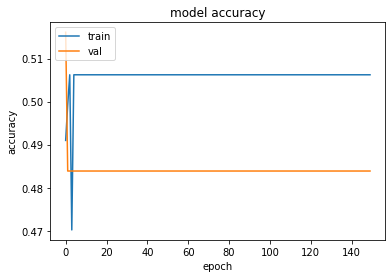

In [ ]:
fig = plt.figure()
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
fig.savefig('model_accuracy.png')

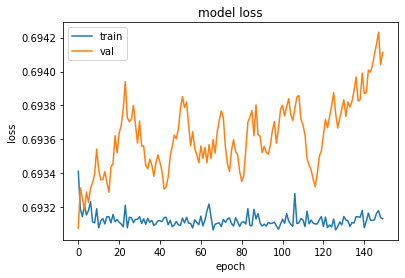

In [ ]:
fig = plt.figure()
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
fig.savefig('model_loss.png')

In [ ]:
!pip install inltk

In [ ]:
!pip install torch==1.3.1+cpu -f https://download.pytorch.org/whl/torch_stable.html


In [ ]:
from inltk.inltk import setup
setup('te')

dataset creation

In [ ]:
import pandas as pd


In [ ]:
from inltk.inltk import get_embedding_vectors
def get_sent_embedd(sentance1):
  vectors = get_embedding_vectors(sentance1, "te")
  sent1=np.average(vectors,axis=0)
  
  return sent1


In [ ]:
nldf =pd.read_excel('/content/Telugu_nlp_dataset_final.xlsx')
nldf = nldf.iloc[: , 1:]
nldf=nldf.dropna()
print(nldf.shape)
s1 = nldf['sentance1'].values
s2 = nldf['sentance2'].values   # independant features
tar = nldf['target'].values		

(1031, 3)


In [ ]:
 nldf['target'].describe()

count    1031.000000
mean        0.500485
std         0.500242
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: target, dtype: float64

In [ ]:
nlX_train1, nlX_val_test1,nlX_train2,nlX_val_test2, nly_train, nly_val_test = train_test_split(s1,s2, tar, test_size=0.2, random_state=42)

In [ ]:
len(nlX_val_test1)

207

In [ ]:
int(nly_train[i])

NameError: ignored

In [ ]:
sum=0
leng=0
for i in range(0,207):
  if int(nly_train[i])==0:
    leng=leng+1
    sum=sum+len(nlX_val_test1[i].split(" "))
leng

94

In [ ]:
sum/len(nly_train)

2.4599514563106797

In [ ]:
sum(nly_train)

417.0

In [ ]:
nlX_val_test1.info()

(207,)

In [ ]:
s1=preprocessing(s1)
s2=preprocessing(s2)

In [ ]:
features=['f'+str(i) for i in range(410)]
nldfnew=pd.DataFrame(columns=features)

for i in range(len(s1)):
  sentence_embedding = get_sent_embedd(s1[i])
  nldfnew=nldfnew.append(pd.DataFrame([sentence_embedding], columns=features))

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'fastai.layers.MergeLayer' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.


In [ ]:
features=['f'+str(i) for i in range(410)]
nldfnew1=pd.DataFrame(columns=features)

for i in range(len(s2)):
  sentence_embedding = get_sent_embedd(s2[i])
  nldfnew1=nldfnew1.append(pd.DataFrame([sentence_embedding], columns=features))

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'fastai.layers.MergeLayer' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.


In [ ]:
nldft=tar

In [ ]:
nldfnew.to_csv('/content/nlsentance1.csv')

In [ ]:
nldfnew1.to_csv('/content/nlsentance2.csv')

In [ ]:
#X1 = nldfnew
#X2 = nldfnew1
#y = nldft
#kf = KFold(n_splits=10)

#for train_index ,test_index in kf.split(X1):
#    print("TRAIN:", train_index, "TEST:", test_index)
#    nlX_train1, nlX_val_test1 = X1[train_index], X1[test_index]
#    nlX_train2, nlX_val_test2 = X2[train_index], X2[test_index]
#    nly_train, nly_val_test = y[train_index], y[test_index]


nlX_train1, nlX_val_test1,nlX_train2,nlX_val_test2, nly_train, nly_val_test = train_test_split(nldfnew,nldfnew1, nldft, test_size=0.2, random_state=42)

NameError: ignored

In [ ]:
model_2 = sentance_model(input_shape=(410,))
model_2.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 410)]        0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None, 410)]        0           []                               
                                                                                                  
 flatten_26 (Flatten)           (None, 410)          0           ['input_27[0][0]']               
                                                                                                  
 flatten_27 (Flatten)           (None, 410)          0           ['input_28[0][0]']               
                                                                                           

In [ ]:
filepath ='model_inltl.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_alpha = ReduceLROnPlateau(monitor ='val_loss', factor = 0.2, patience = 1, min_lr = 0.001)
callbacks = [checkpoint,reduce_alpha] 

In [ ]:
no_epochs = 150
batch_s=10
reduce_lr =ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                            patience=5, min_lr=0.01)
history2=model_2.fit([nlX_train1, nlX_train2],
          y=nly_train,
          epochs=no_epochs,
          batch_size=batch_s,
          validation_data=([nlX_val_test1,nlX_val_test2],nly_val_test),callbacks=callbacks)

Epoch 1/150
78/83 [===========================>..] - ETA: 0s - loss: 0.6685 - accuracy: 0.6410
Epoch 1: val_loss improved from inf to 0.58714, saving model to model_inltl.h5
83/83 [==============================] - 1s 6ms/step - loss: 0.6621 - accuracy: 0.6493 - val_loss: 0.5871 - val_accuracy: 0.7440 - lr: 0.0010
Epoch 2/150
67/83 [=======================>......] - ETA: 0s - loss: 0.5601 - accuracy: 0.7418
Epoch 2: val_loss improved from 0.58714 to 0.50720, saving model to model_inltl.h5
83/83 [==============================] - 0s 3ms/step - loss: 0.5446 - accuracy: 0.7536 - val_loss: 0.5072 - val_accuracy: 0.7633 - lr: 0.0010
Epoch 3/150
81/83 [============================>.] - ETA: 0s - loss: 0.4803 - accuracy: 0.7753
Epoch 3: val_loss improved from 0.50720 to 0.49563, saving model to model_inltl.h5
83/83 [==============================] - 0s 3ms/step - loss: 0.4837 - accuracy: 0.7731 - val_loss: 0.4956 - val_accuracy: 0.7826 - lr: 0.0010
Epoch 4/150
63/83 [=====================>...

In [ ]:
model_2.evaluate([nlX_val_test1,nlX_val_test2],nly_val_test)

7/7 [==============================] - 0s 2ms/step - loss: 2.5467 - accuracy: 0.7585


[2.546682119369507, 0.7584540843963623]

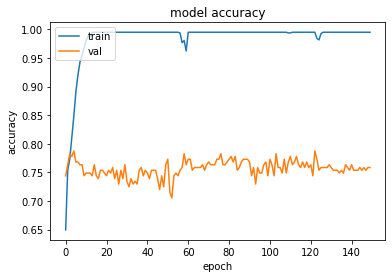

In [ ]:
fig = plt.figure()
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
fig.savefig('model_accuracy.png')

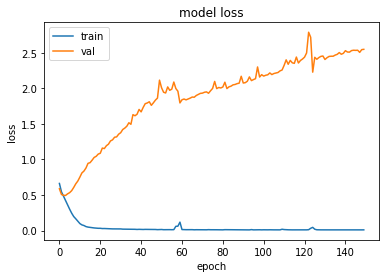

In [ ]:
fig = plt.figure()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'val'], loc='upper left')
fig.savefig('model_loss.png')

In [ ]:
m2_pred=model_2.predict([nlX_val_test1,nlX_val_test2])

In [ ]:
print("precision= ",precision(nly_val_test, m2_pred))
print("recall= ",recall(nly_val_test, m2_pred))
print("f1_score= ",f1_score(nly_val_test, m2_pred))


precision=  0.7406115195228262
recall=  0.7337764267958058
f1_score=  0.7371781298079431


In [ ]:
data =pd.read_excel('/content/Telugu_nlp_dataset_final.xlsx')
data = data.iloc[: , 1:]
data=data.dropna()
print(data.shape)
	

(1031, 3)


lstm model creation


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data["sentance1"].values+data["sentance2"].values)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 4531


In [ ]:
max_len = 25
q1_texts_seq = tokenizer.texts_to_sequences(data["sentance1"].values)
q2_texts_seq = tokenizer.texts_to_sequences(data["sentance2"].values)

q1_texts_seq = pad_sequences(q1_texts_seq,maxlen=max_len)
q2_texts_seq = pad_sequences(q2_texts_seq,maxlen=max_len)

In [ ]:
X = np.stack((q1_texts_seq, q2_texts_seq), axis=1)
y = data["target"].values

cross validation

In [ ]:
import numpy as np
from sklearn.model_selection import RepeatedKFold
kf = RepeatedKFold(n_splits=20, n_repeats=2, random_state=42)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]



In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Get Question 1/2  train and test features
s1_X_train = X_train[:,0]
s2_X_train = X_train[:,1]
s1_X_test = X_test[:,0]
s2_X_test = X_test[:,1]

In [ ]:
embeddings_index = {} # empty dictionary
f = open(os.path.join("/content/generated_embedding_2.txt"), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 1705 word vectors.


In [ ]:
embedding_dim = 410

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
from keras import backend as K

def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

In [ ]:
def lstm_model(input_shape,embeddings_dim, embeddings_matrix, vocab_size,
                      max_seq_length, trainable_embeddings,
                      lstm_hidden_units):
    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)


    common_embed = Embedding(vocab_size, embeddings_dim, weights=[embeddings_matrix], input_length=max_seq_length, trainable=trainable_embeddings) 
    lstm_1 = common_embed(input_1)
    lstm_2 = common_embed(input_2)


    common_lstm = LSTM(lstm_hidden_units,return_sequences=True, activation="relu")
    vector_1 = common_lstm(lstm_1)
    vector_1 = Flatten()(vector_1)

    vector_2 = common_lstm(lstm_2)
    vector_2 = Flatten()(vector_2)

    x3 = Subtract()([vector_1, vector_2])
    x3 = Multiply()([x3, x3])

    x1_ = Multiply()([vector_1, vector_1])
    x2_ = Multiply()([vector_2, vector_2])
    x4 = Subtract()([x1_, x2_])
        
    x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([vector_1, vector_2])
        
    conc = Concatenate(axis=-1)([x5,x4, x3])

    x = Dense(100, activation="relu", name='conc_layer')(conc)
    x = Dropout(0.01)(x)
    out = Dense(1, activation="sigmoid", name = 'out')(x)

    model = Model([input_1, input_2], out)
    optimizer = optimizers.Adam()
    model.compile(optimizer=optimizer,
                loss="binary_crossentropy",
                metrics=['accuracy'])
    return model


In [ ]:
trainable_embeddings = False
lstm_hidden_units = 50
input_shape = (max_len,)
model_lstm = lstm_model(input_shape,
                      embedding_dim, embedding_matrix, vocab_size,
                      max_len, trainable_embeddings,lstm_hidden_units)
model_lstm.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
filepath ='model_lstm.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# Defining a helper function to reduce the learning rate each time 
# the learning plateaus 
reduce_alpha = ReduceLROnPlateau(monitor ='val_loss', factor = -0.2, patience = 1, min_lr = 0.001)
# stop traning if there increase in loss
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
callbacks = [checkpoint,reduce_alpha] 

In [ ]:
epochs = 70
batch_size = 32
history_L = model_lstm.fit(x=[s1_X_train, s2_X_train],
                    y=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=([s1_X_test, s2_X_test], y_test),callbacks=callbacks)

Epoch 1/70
31/31 [==============================] - ETA: 0s - loss: 0.6824 - accuracy: 0.5041
Epoch 1: val_loss improved from inf to 0.60310, saving model to model_lstm.h5
31/31 [==============================] - 4s 55ms/step - loss: 0.6824 - accuracy: 0.5041 - val_loss: 0.6031 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 2/70
31/31 [==============================] - ETA: 0s - loss: 0.6047 - accuracy: 0.6929
Epoch 2: val_loss improved from 0.60310 to 0.57482, saving model to model_lstm.h5
31/31 [==============================] - 1s 44ms/step - loss: 0.6047 - accuracy: 0.6929 - val_loss: 0.5748 - val_accuracy: 0.7451 - lr: 0.0010
Epoch 3/70
30/31 [============================>.] - ETA: 0s - loss: 0.5147 - accuracy: 0.7635
Epoch 3: val_loss improved from 0.57482 to 0.53515, saving model to model_lstm.h5
31/31 [==============================] - 1s 44ms/step - loss: 0.5123 - accuracy: 0.7673 - val_loss: 0.5351 - val_accuracy: 0.7451 - lr: 0.0010
Epoch 4/70
31/31 [=============================

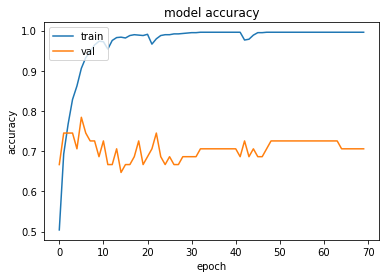

In [ ]:
fig = plt.figure()
plt.plot(history_L.history['accuracy'])
plt.plot(history_L.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
fig.savefig('model_accuracy.png')

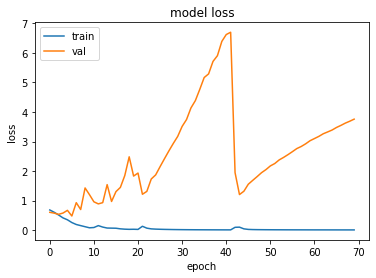

In [ ]:
fig = plt.figure()
plt.plot(history_L.history['loss'])
plt.plot(history_L.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'val'], loc='upper left')
fig.savefig('model_loss.png')

In [ ]:
pred_lstm=model_lstm.predict([s1_X_test, s2_X_test])

In [ ]:
pred_lstm

array([[1.000000e+00],
       [7.429372e-01],
       [9.445873e-01],
       [5.579244e-01],
       ...,
       [0.000000e+00],
       [2.984460e-06],
       [9.574469e-01],
       [2.851800e-08]], dtype=float32)

In [ ]:
print("precision= ",precision(y_test, pred_lstm))
print("recall= ",recall(y_test, pred_lstm))
print("f1_score= ",f1_score(y_test, pred_lstm))


precision=  0.6480792692618614
recall=  0.7790035324274868
f1_score=  0.7075357357686286


In [ ]:
y_test

array([0., 0., 0., 0., ..., 0., 0., 0., 0.])

BiLSTM


In [ ]:
def bilstm_model(input_shape,embeddings_dim, embeddings_matrix, vocab_size,
                      max_seq_length, trainable_embeddings,
                      bilstm_hidden_units):
    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)


    common_embed = Embedding(vocab_size, embeddings_dim, weights=[embeddings_matrix], input_length=max_seq_length, trainable=trainable_embeddings) 
    lstm_1 = common_embed(input_1)
    lstm_2 = common_embed(input_2)


    common_Bilstm = Bidirectional(LSTM(bilstm_hidden_units,return_sequences=True, activation="relu"))
    vector_1 = common_Bilstm(lstm_1)
    vector_1 = Flatten()(vector_1)

    vector_2 = common_Bilstm(lstm_2)
    vector_2 = Flatten()(vector_2)

    x3 = Subtract()([vector_1, vector_2])
    x3 = Multiply()([x3, x3])

    x1_ = Multiply()([vector_1, vector_1])
    x2_ = Multiply()([vector_2, vector_2])
    x4 = Subtract()([x1_, x2_])
        
    x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([vector_1, vector_2])
        
    conc = Concatenate(axis=-1)([x5,x4, x3])

    x = Dense(100, activation="relu", name='conc_layer')(conc)
    x = Dropout(0.01)(x)
    out = Dense(1, activation="sigmoid", name = 'out')(x)

    model = Model([input_1, input_2], out)
    optimizer = optimizers.Adam()
    model.compile(optimizer=optimizer,
                loss="binary_crossentropy",
                metrics=['accuracy'])
    return model

In [ ]:
trainable_embeddings = False
bilstm_hidden_units = 50
input_shape = (max_len,)
model_bilstm = bilstm_model(input_shape,
                      embedding_dim, embedding_matrix, vocab_size,
                      max_len, trainable_embeddings,bilstm_hidden_units)
model_bilstm.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 25)]         0           []                               
                                                                                                  
 input_36 (InputLayer)          [(None, 25)]         0           []                               
                                                                                                  
 embedding_11 (Embedding)       (None, 25, 410)      1857710     ['input_35[0][0]',               
                                                                  'input_36[0][0]']               
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 25, 100)     184400      ['embedding_11[0][0]',    

In [ ]:
filepath ='model_bilstm.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# Defining a helper function to reduce the learning rate each time 
# the learning plateaus 
reduce_alpha = ReduceLROnPlateau(monitor ='val_loss', factor = 0.2, patience = 1, min_lr = 0.001)
# stop traning if there increase in loss
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
callbacks = [checkpoint,reduce_alpha] 

In [ ]:
epochs = 70
batch_size = 32
history_bil = model_bilstm.fit(x=[s1_X_train, s2_X_train],
                    y=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=([s1_X_test, s2_X_test], y_test),callbacks=callbacks)

Epoch 1/70
31/31 [==============================] - ETA: 0s - loss: 0.6763 - accuracy: 0.5367
Epoch 1: val_loss improved from inf to 0.59584, saving model to model_bilstm.h5
31/31 [==============================] - 8s 104ms/step - loss: 0.6763 - accuracy: 0.5367 - val_loss: 0.5958 - val_accuracy: 0.6863 - lr: 0.0010
Epoch 2/70
31/31 [==============================] - ETA: 0s - loss: 0.5918 - accuracy: 0.7010
Epoch 2: val_loss improved from 0.59584 to 0.55673, saving model to model_bilstm.h5
31/31 [==============================] - 3s 84ms/step - loss: 0.5918 - accuracy: 0.7010 - val_loss: 0.5567 - val_accuracy: 0.7843 - lr: 0.0010
Epoch 3/70
31/31 [==============================] - ETA: 0s - loss: 0.4749 - accuracy: 0.8010
Epoch 3: val_loss improved from 0.55673 to 0.54360, saving model to model_bilstm.h5
31/31 [==============================] - 3s 84ms/step - loss: 0.4749 - accuracy: 0.8010 - val_loss: 0.5436 - val_accuracy: 0.7451 - lr: 0.0010
Epoch 4/70
31/31 [======================

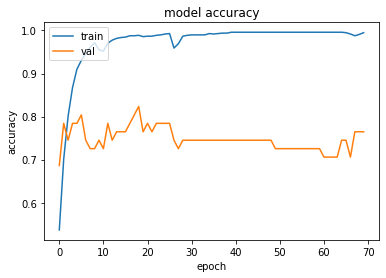

In [ ]:
fig = plt.figure()
plt.plot(history_bil.history['accuracy'])
plt.plot(history_bil.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
fig.savefig('model_accuracy.png')

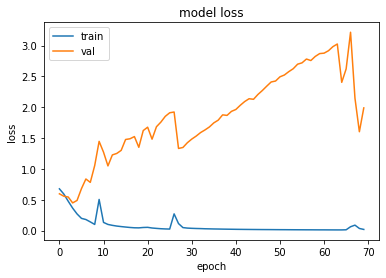

In [ ]:
fig = plt.figure()
plt.plot(history_bil.history['loss'])
plt.plot(history_bil.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'val'], loc='upper left')
fig.savefig('model_loss.png')

In [ ]:
pred_bilstm=model_bilstm.predict([s1_X_test, s2_X_test])

In [ ]:
print("precision= ",precision(y_test, pred_bilstm))
print("recall= ",recall(y_test, pred_bilstm))
print("f1_score= ",f1_score(y_test, pred_bilstm))


precision=  0.7006968535023523
recall=  0.7992215418815612
f1_score=  0.7467233169100108


In [ ]:
!pip install stanza

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 574 kB 30.2 MB/s 
     |████████████████████████████████| 175 kB 53.1 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=8e2155001eff9df96e0cde736670daeafa7a8a9480d503b37e2ce72ec38a7383
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [ ]:
def lammatizer(sentance):
  lemmatizer = stanza.Pipeline('te', processors='tokenize,pos,lemma')
  doc = te_pos_tagger(sentance)
  lemmatized=''
  posarr=[]
  for sentence in doc.sentences:
    for word in sentence.words:
        lemmatized=lemmatized+word.lemma+" "
        posarr.append(word.pos)
  return lemmatized

In [ ]:
import stanza
te_pos_tagger = stanza.Pipeline('te', processors='tokenize,pos,lemma')
doc = te_pos_tagger('సింక్ ముందు ఉన్నారు. ')
for sentence in doc.sentences:
  for word in sentence.words:
      print("%s\t%s\t%s" % (word.text, word.lemma, word.pos))

In [ ]:
from inltk.inltk import tokenize

def tokenizer(sent):
  return tokenize(sent, "te")

s ="ఆమెకు జంతువులంటే ఇష్టం. 1984"

tokenizer(s)


ModuleNotFoundError: ignored

In [ ]:
import numpy as np

def cosine_similarity(v1,v2):
  l1=np.sqrt(sum(np.multiply(v1,v1)))
  l2=np.sqrt(sum(np.multiply(v2,v2)))
  dist_vec=np.dot(v1/l1,v2/l2)
  return dist_vec


In [ ]:
def similarity_matrix(embedding_array1,embedding_array2):
  final_array=[]
  for i in embedding_array1:
    each_in_1=[]
    for j in embedding_array2:
      similarity=cosine_similarity(i,j)
      each_in_1.append(similarity)
    final_array.append(each_in_1)
  return final_array


In [ ]:
esent1= get_embedding_vectors(sent1,'te')
esent2= get_embedding_vectors(sent2,'te')

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by accessing the object's source attribute o

In [ ]:
esent1

[array([ 0.072249, -0.129393,  0.006312, -0.119892, ...,  0.113501,  0.059413,  0.006185,  0.010489], dtype=float32),
 array([ 0.090813, -0.020606,  0.169349, -0.123937, ...,  0.055845, -0.151176, -0.01304 ,  0.082535], dtype=float32),
 array([-0.063162, -0.069365, -0.030838,  0.160333, ...,  0.008192,  0.112987,  0.024391, -0.078399], dtype=float32),
 array([ 0.130163, -0.068263,  0.009511, -0.080448, ...,  0.079375, -0.144218, -0.044858, -0.094123], dtype=float32),
 array([ 0.025459,  0.019397, -0.218281,  0.067287, ...,  0.078206,  0.094681, -0.239771,  0.04246 ], dtype=float32),
 array([-0.001445,  0.146372,  0.191054, -0.033626, ...,  0.298906, -0.064925, -0.257128,  0.243472], dtype=float32)]

In [ ]:
sent1="నేను నా దేశాన్ని ప్రేమిస్తున్నాను"
sent2="నా దేశ పౌరుడిగా నేను గర్విస్తున్నాను"

In [ ]:
sim=similarity_matrix(esent1,esent2)

In [ ]:
np.array(sim)

array([[ 0.427008, -0.033004,  0.003533, -0.008078,  1.      ,  0.272197,  0.159385, -0.023103],
       [ 1.      ,  0.227013, -0.058827, -0.199251,  0.427008,  0.021602, -0.186183,  0.305453],
       [-0.137293,  0.401502,  0.052873,  0.144469,  0.025494,  0.155557,  0.074171, -0.063282],
       [ 0.185021,  0.016727,  0.061756,  0.04596 ,  0.205627,  0.326643,  0.059943, -0.035857],
       [-0.186183, -0.254637,  0.0553  ,  0.256758,  0.159385,  0.198766,  1.      , -0.131876],
       [ 0.305453,  0.121071, -0.082215, -0.068251, -0.023103, -0.126426, -0.131876,  1.      ]], dtype=float32)

In [ ]:
np.array(sim).shape

(6, 8)